## Setup

In [22]:
import ugradio
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy.stats import norm, linregress
from scipy.optimize import curve_fit, least_squares
from uncertainties import ufloat
from scipy.signal import find_peaks
from numpy.linalg import lstsq
import os
import glob
import time
import datetime
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u

In [23]:
# Consistent Plot Params
titleSize = 15
axisSize = 15
legendSize = 13
graphSizeSingle = (8, 6)
graphSizeDouble = (15, 6)
graphSizeHorizontal = (20, 6)

## Data Extraction

In [24]:
def extractRawData(folder, filename):
    prefix = "ugastro\\Lab3Data\\" + folder
    raw_data = np.load(prefix + filename, allow_pickle=True)
    return raw_data

def getDataBlocks(data, buffer=10, num_blocks=2030):
    new_data = np.zeros((num_blocks, 1024), dtype=complex)
    for i, block in enumerate(data[buffer:num_blocks+buffer]):
        new_data[i] = normalize(block['corr01'])
    return new_data

def getRealImagData(data, buffer=10, num_blocks=2030):
    real_data = np.zeros((num_blocks, 1024), dtype=float)
    imag_data = np.zeros((num_blocks, 1024), dtype=complex)
    for i, block in enumerate(data[buffer:num_blocks+buffer]):
        #real_data[i] = normalize(block['corr01'].real)
        #imag_data[i] = normalize(block['corr01'].imag)
        real_data[i] = block['corr01'].real
        imag_data[i] = block['corr01'].imag
    return real_data, imag_data

def getComplexData(data, buffer=10, num_blocks=2030):
    complex_data = np.zeros((num_blocks, 1024), dtype=complex)
    for i, block in enumerate(data[buffer:num_blocks+buffer]):
        complex_data[i] = block['corr01'].real + (1j * block['corr01'].imag)
    complex_data = normalize(complex_data)
    return complex_data

def getDataSingleBlock(data, block=1):
    real = data['time_data'][block][:, 0]
    imag = data['time_data'][block][:, 1]
    return normalize(real + (1j * imag))

def getHorizonRawData(folder, extension="npy"):
    # Load and merge many files
    directory = "ugastro\\Lab3Data\\" + folder
    file_paths = sorted(glob.glob(os.path.join(directory, f"*.{extension}")))
    if not file_paths:
        print("No files found. Check the directory path and file extension.")
        return None
    
    data = []
    for file in file_paths:
        try:
            data.append(np.load(file, allow_pickle=True))
        except Exception as e:
            print(f"Error loading {file}: {e}")

    if data:
        merged_data = np.concatenate(data, axis=0)
        return merged_data
    else:
        print("No valid data files loaded.")
        return None

def normalize(data):
    return (data - np.mean(data)) #/ np.std(data)

def getUnixTimes(data, buffer=10):
    # Takes raw data
    times = [(data[i+buffer]['time']) for i in range(len(data)-buffer)]

    return times

def getTimesJD(data, buffer=10):
    # Takes raw data
    times = [(data[i+buffer]['time']/86400)+2440587.5 for i in range(len(data)-buffer)]

    return times

def getTimesLocal(data):
    # Takes raw data
    times = [time.gmtime(data[i]['time']) for i in range(len(data))]
    return times

def timestepToSec(timestep):
    # Takes a time step in seconds and converts to a datetime object
    return 1.25 * timestep


In [25]:
# Week 1
folder = "Week1_Testing\\"
data_test_raw = extractRawData(folder, "test_observatin_data.npy")
data_test = getDataBlocks(data_test_raw)
data_test_2_raw = extractRawData(folder, "Mar12_test_observation_data.npz")
data_test_2 = getDataBlocks(data_test_2_raw['arr_0'])

data_horizon_raw_1 = extractRawData(folder, "Mar13_12hour_observation_data.npz")
data_horizon_1 = getDataBlocks(data_horizon_raw_1['arr_0'], )

data_horizon_raw_2 = getHorizonRawData("Mar15_Observation")
data_horizon_2 = normalize(getDataBlocks(data_horizon_raw_2, buffer=0, num_blocks=28720))
print(len(data_horizon_2))

28720


In [26]:
horizon_real, horizon_imag = getRealImagData(data_horizon_raw_2, buffer=0, num_blocks=28720)
print(len(horizon_real))
print(len(horizon_imag))

horizon_complex = getComplexData(data_horizon_raw_2, buffer=0, num_blocks=28720)
print(horizon_complex.shape)
print(horizon_complex[0])

28720
28720
(28720, 1024)
[6.24767575+0.02841903j 0.46377666+0.02841903j 0.46377666+0.02841903j ...
 0.46377666+0.02841903j 0.46377666+0.02841903j 0.46377666+0.02841903j]


In [31]:
time_data = getUnixTimes(data_horizon_raw_2, buffer=0)
time_data_jd = getTimesJD(data_horizon_raw_2, buffer=0)
LOC = EarthLocation(lat=37.873199*u.deg, lon=-122.257063*u.deg, height=120*u.m)
times = Time(time_data, format='unix', location=LOC)
LSTs = times.sidereal_time('apparent', longitude=LOC.lon).radian % (2 * np.pi)

RAs, DECs, HAs = np.zeros(len(time_data)), np.zeros(len(time_data)), np.zeros(len(time_data))
for i in range(len(time_data)):
    ra, dec = ugradio.coord.sunpos(time_data_jd[i])
    RAs[i] = np.radians(ra)
    HAs[i] = LSTs[i] - np.radians(ra)
    DECs[i] = np.radians(dec)
    
w_earth = (2 * np.pi) / (24 * 60 * 60)
wavelen = 0.025
L = np.radians(37.873199)
b_ew_guess = 20
b_ns_guess = 0

In [32]:
print(len(time_data))
step = 2000
for i in range(0, len(HAs), step):
    print(f"jd = {time_data_jd[i]}, RA = {RAs[i]}, LST = {LSTs[i]}, HAs = {HAs[i]}")
    print(HAs[i])

28720
jd = 2460750.1474417555, RA = 6.202195307541056, LST = 4.96218682183104, HAs = -1.2400084857100167
-1.2400084857100167
jd = 2460750.1763795596, RA = 6.2026573498283755, LST = 5.144506198724753, HAs = -1.0581511511036226
-1.0581511511036226
jd = 2460750.2053176025, RA = 6.203119382418845, LST = 5.326827079928264, HAs = -0.8762923024905813
-0.8762923024905813
jd = 2460750.2342548883, RA = 6.20358138945035, LST = 5.509143192679575, HAs = -0.6944381967707747
-0.6944381967707747
jd = 2460750.2631916376, RA = 6.204043374488607, LST = 5.691455924520362, HAs = -0.5125874499682448
-0.5125874499682448
jd = 2460750.2921294933, RA = 6.204505363802754, LST = 5.873775626062808, HAs = -0.3307297377399463
-0.3307297377399463
jd = 2460750.321067571, RA = 6.2049673433150305, LST = 6.056096729467852, HAs = -0.14887061384717892
-0.14887061384717892
jd = 2460750.3500040104, RA = 6.205429283360815, LST = 6.2384075080091845, HAs = 0.03297822464836919
0.03297822464836919
jd = 2460750.3789423867, RA = 6.

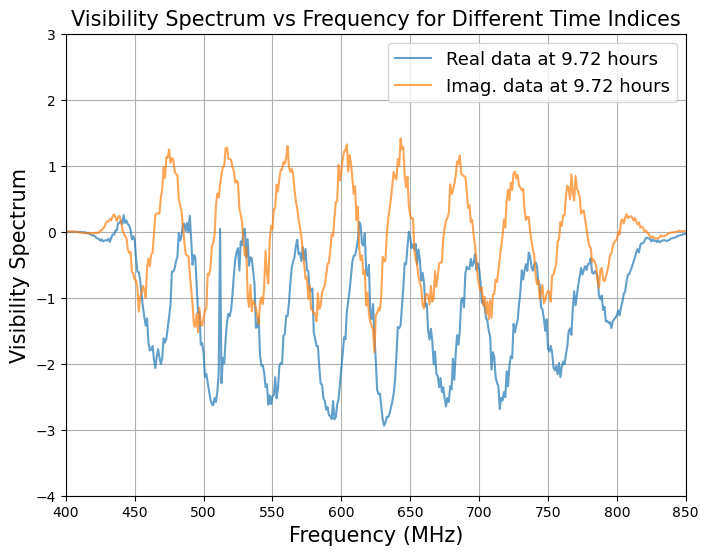

In [33]:
def plot_power_spectrum(data, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)

    for index in indices:
        spectrum = data[index]
        plt.plot(spectrum, label=f"time index = {index}", alpha=0.7)
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Visibility Spectrum", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Visibility Spectrum vs Frequency for Different Time Indices", size=titleSize)
    plt.grid()
    plt.show()

def plot_power_spectrum_complex(data_real, data_imag, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    times = [(x*1.25)/3600 for x in range(len(data_real))]

    for index in indices:
        spectrum_real = data_real[index]
        spectrum_imag = data_imag[index]
        plt.plot(spectrum_real, label=f"Real data at {round(times[index], 2)} hours", alpha=0.7)
        plt.plot(spectrum_imag, label=f"Imag. data at {round(times[index], 2)} hours", alpha=0.7)

    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Visibility Spectrum", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Visibility Spectrum vs Frequency for Different Time Indices", size=titleSize)
    plt.grid()
    plt.show()

#plot_power_spectrum(data_horizon_2, indices=[23000, 28000], xlim=(400, 850), ylim=(-4, 3))
#plot_power_spectrum_complex(horizon_real, horizon_imag, indices=[10000], xlim=(400, 850), ylim=(-4, 3))
#plot_power_spectrum_complex(horizon_real, horizon_imag, indices=[23000], xlim=(400, 850), ylim=(-4, 3))
plot_power_spectrum_complex(horizon_real, horizon_imag, indices=[28000], xlim=(400, 850), ylim=(-4, 3))

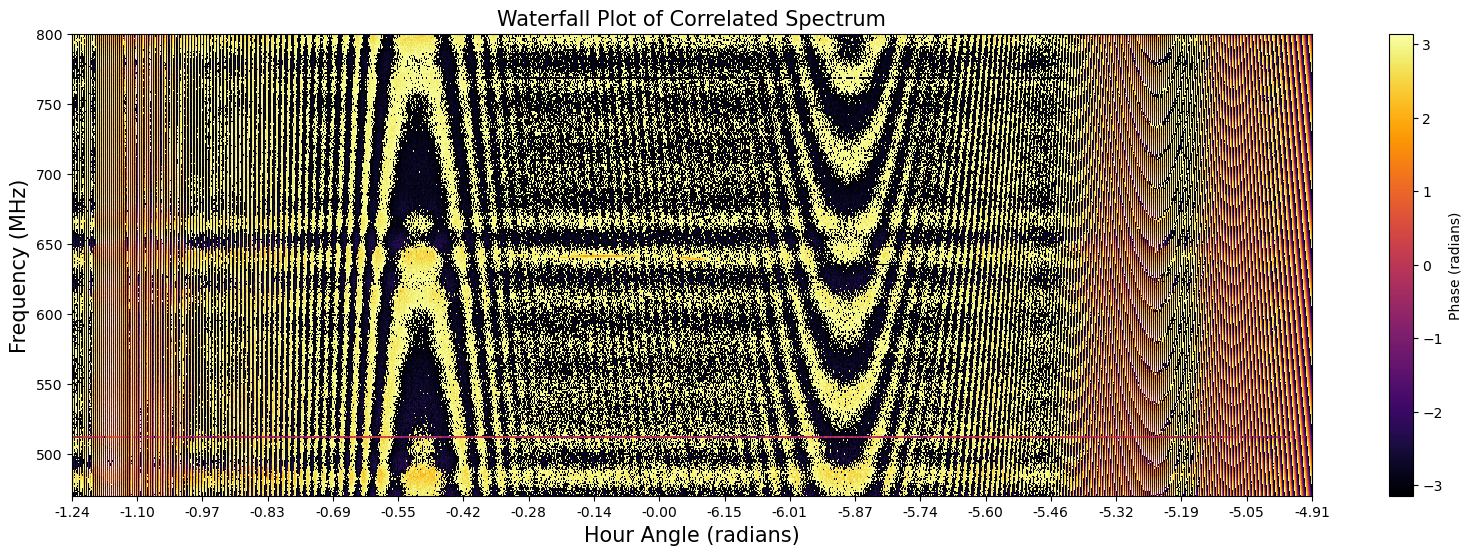

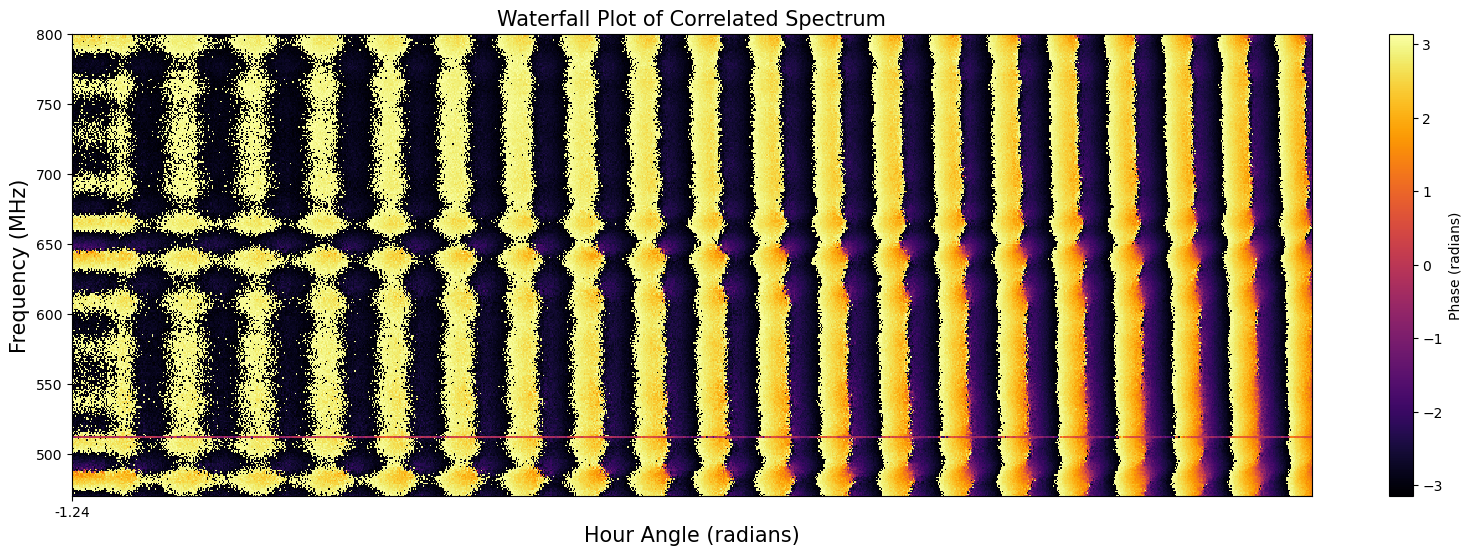

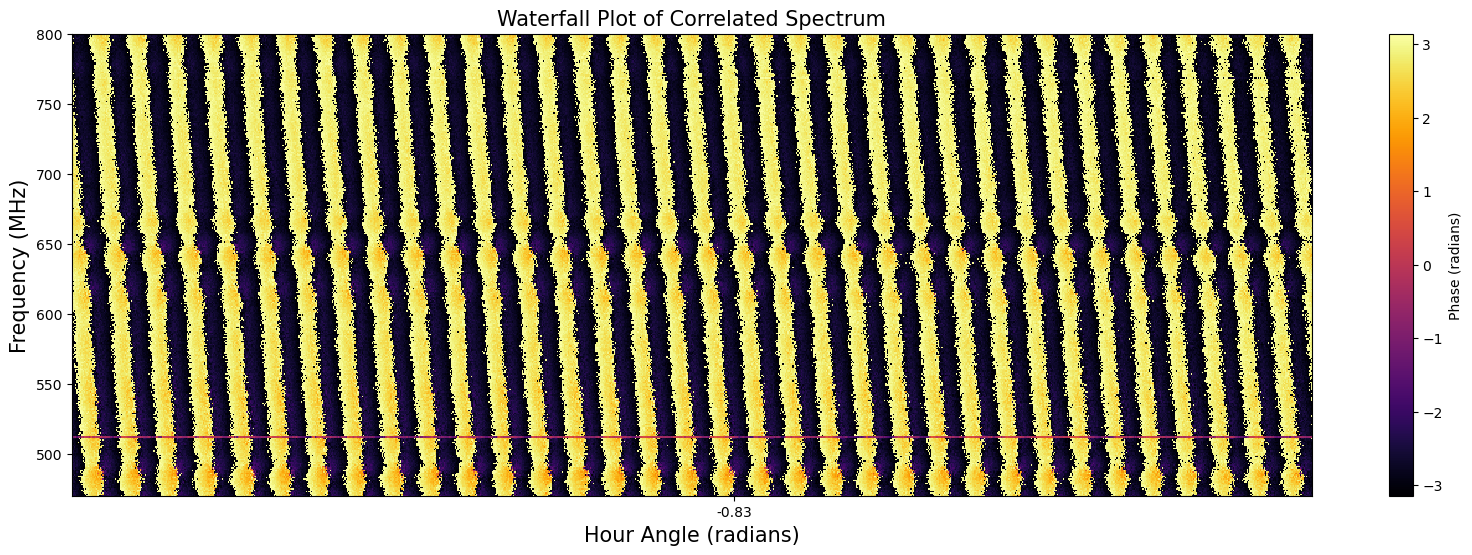

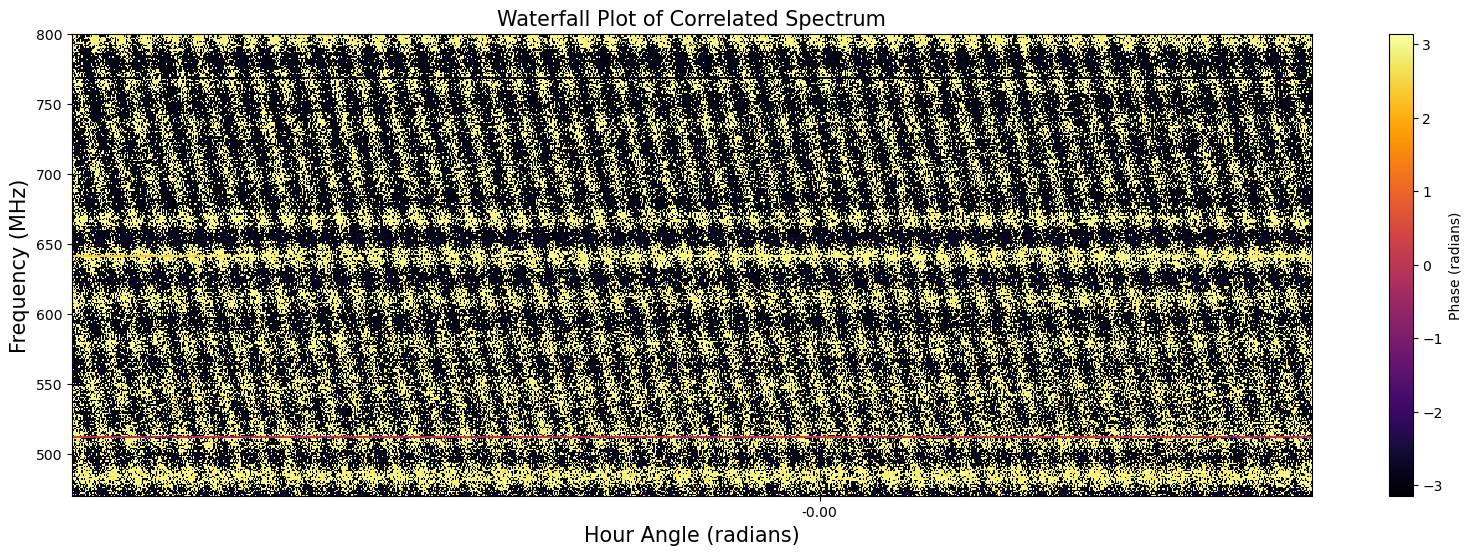

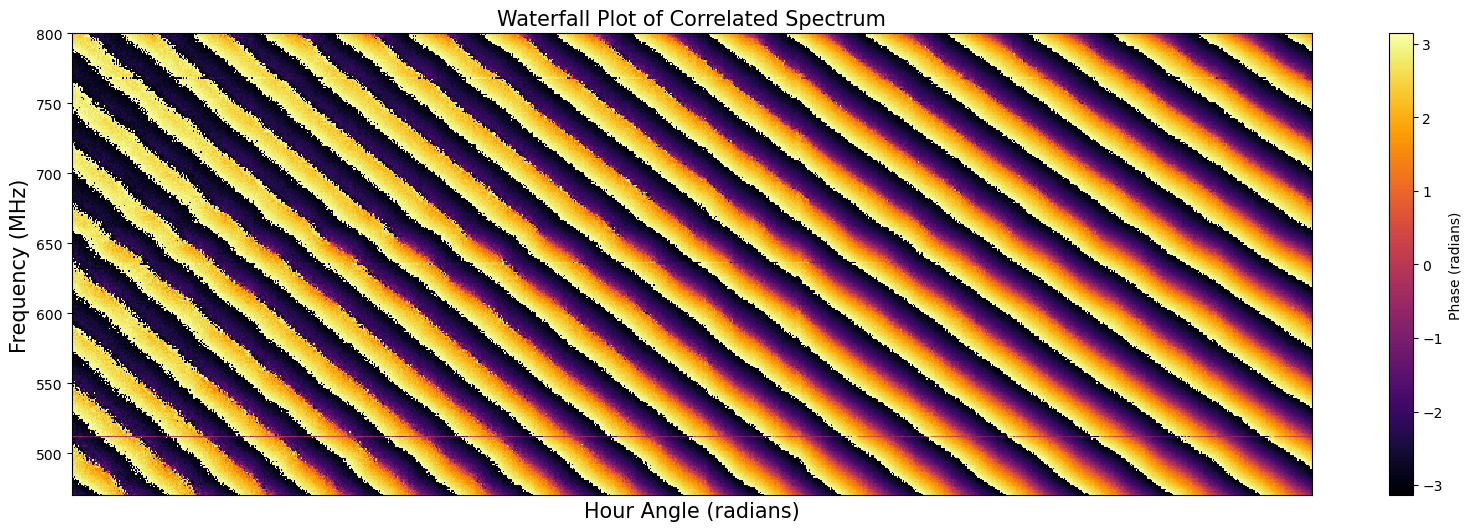

In [34]:
def plot_waterfall(data, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    plt.imshow(np.abs(data), aspect='auto', cmap='inferno', norm='linear',
                interpolation='nearest', origin='lower')
    plt.colorbar(label="Power (Arbitrary Scale)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum", size=titleSize)
    plt.show()

def plot_waterfall_corr(data, baseline, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    plt.imshow(np.abs(data) - np.abs(baseline), aspect='auto', cmap='inferno', norm='linear',
               interpolation='nearest', origin='lower')
    plt.colorbar(label="Power (Arbitrary Scale)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum", size=titleSize)
    plt.show()

def plot_waterfall_any(data_real, data_imag, mode='real', xlim=None, ylim=None):
    plt.figure(figsize=graphSizeHorizontal)

    if mode == 'real':
        display_data = (data_real.T).astype(float)
        label = "Real Component"
    elif mode == 'imag':
        display_data = (data_imag.T).astype(float)
        label = "Imaginary Component"
    elif mode == 'phase (real)':
        display_data = (np.angle(data_real.T)).astype(float)
        label = "Real Phase (radians)"
    elif mode == 'phase (imag)':
        display_data = (np.angle(data_imag.T)).astype(float)
        label = "Imaginary Phase (radians)"
    else:
        raise ValueError(f"Unknown mode '{mode}'. Choose from 'real', 'imag', 'phase (real)', or phase (imag).")
    
    plt.imshow(display_data, aspect='auto', cmap='inferno', norm='linear', interpolation='nearest', origin='lower')
    plt.colorbar(label=label)
    plt.xlabel("Time Step", fontsize=axisSize)
    plt.ylabel("Frequency (MHz)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(f"Waterfall Plot of {label} of Correlated Spectrum", size=titleSize)
    plt.show()

def plot_waterfall_complex(data_complex, xunits='radians', nticks=20, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeHorizontal)
    display_data = (np.angle(data_complex.T))
    plt.imshow(display_data, aspect='auto', cmap='inferno', norm='linear', interpolation='nearest', origin='lower')
    plt.colorbar(label="Phase (radians)")

    nt = data_complex.shape[0]
    xticks = np.linspace(0, nt - 1, nticks, dtype=int)
    if xunits == 'degrees':
        xlabels = np.rad2deg(HAs[xticks]) + 360
        xlabel = "Hour Angle (degrees)"
    else:
        xlabels = HAs[xticks]
        xlabel = "Hour Angle (radians)"

    plt.xticks(xticks, [f"{val:.2f}" for val in xlabels])
    plt.xlabel(xlabel, fontsize=axisSize)
    plt.ylabel("Frequency (MHz)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(f"Waterfall Plot of Correlated Spectrum", size=titleSize)
    plt.show()


#plot_waterfall(data_test)
#plot_waterfall(data_test_2)
#plot_waterfall_corr(data_test[:400], data_test_2[:400], xlim=(220, 400))
#plot_waterfall(data_horizon_2, xlim=(470, 800))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(0, 1000))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(4000, 5000))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(12500, 13000))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(22000, 23000))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(25000, 28600))

#plot_waterfall(horizon_real)
#plot_waterfall_any(horizon_real, horizon_imag, mode='real', ylim=(470, 800))
#plot_waterfall_any(horizon_real, horizon_imag, mode='imag', ylim=(470, 800))
#plot_waterfall_any(horizon_real, horizon_imag, mode='phase (real)', ylim=(470, 800))
#plot_waterfall_any(horizon_real, horizon_imag, mode='phase (imag)', ylim=(470, 800))
#
#plot_waterfall_any(horizon_real, horizon_imag, mode='phase (imag)', ylim=(470, 800), xlim=(0, 1000))
#plot_waterfall_any(horizon_real, horizon_imag, mode='phase (imag)', ylim=(470, 800), xlim=(13000, 14000))

plot_waterfall_complex(horizon_complex, ylim=(470, 800))
plot_waterfall_complex(horizon_complex, ylim=(470, 800), xlim=(0, 1000))
plot_waterfall_complex(horizon_complex, ylim=(470, 800), xlim=(4000, 5000))
plot_waterfall_complex(horizon_complex, ylim=(470, 800), xlim=(13000, 14000))
plot_waterfall_complex(horizon_complex, ylim=(470, 800), xlim=(26000, 27000))

In [35]:
def plot_time_delay(data, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    times = [2*i for i in range(len(data[0]))] # 2ms per sample

    for index in indices:
        time_signal = np.abs(ifft(data[index]))
        amplitude = np.abs(time_signal)
        threshold = 0.2 * np.max(amplitude)
        peaks, properties = find_peaks(amplitude, height=threshold)
        if index == 0:
            print(f"Peak = {peaks}")

        plt.plot(times, amplitude, label=f"Time Index = {index}", alpha=0.7)
        plt.scatter(peaks*2, amplitude[peaks], color='r', marker='o', alpha=0.7)
    plt.xlabel("Time Delay (ms)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Power Spectrum vs Time Delay", size=titleSize)
    plt.grid()
    plt.show()
    return peaks, properties

def plot_time_delay_corr(data, baseline, indices=[100], offset=0, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    times = [2*i for i in range(len(data[0]))] # 2ms per sample

    for index in indices:
        time_signal = np.abs(ifft(data[index]))
        time_signal_baseline = np.abs(ifft(baseline[index]))
        amplitude = np.abs(time_signal)
        amplitude_baseline = np.abs(time_signal_baseline)
        amplitude -= amplitude_baseline
        threshold = 0.2 * np.max(amplitude)
        peaks, properties = find_peaks(amplitude, height=threshold)

        plt.plot(times, amplitude, label=f"Time Index = {offset+index}", alpha=0.7)
        plt.scatter(peaks*2, amplitude[peaks], color='r', marker='o', alpha=0.7)
    plt.xlabel("Time Delay (ms)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Power Spectrum vs Time Delay", size=titleSize)
    plt.grid()
    plt.show()
    return peaks, properties

#plot_time_delay(data_test, indices=[100, 200, 300, 400, 500], xlim=(0, 200))
#plot_time_delay(data_test_2, indices=[100, 200, 300, 400, 500], xlim=(0, 200))
#peaks, amps = plot_time_delay_corr(data_test[:450], data_test_2[:450], indices=[100, 200, 300, 400], xlim=(0, 200))
#print(f"Peaks = {peaks[0]}")
#print(f"Amplitudes = {np.round(amps['peak_heights'][0], 3)}")

#plot_time_delay(data_horizon_2, indices=[100, 500, 1000, 10000, 15000, 20000])
#plot_time_delay_corr(data_horizon_2[28000:28450], data_test_2[:450], indices=[100, 200, 300, 400], offset=28000, xlim=(0, 200))

In [36]:
def plot_phase_evolution(data, freq_bin=512):
    time_steps = np.arange(data.shape[0])
    phases = np.angle(data[:, freq_bin])  # Extract column (frequency bin) and compute phase

    plt.figure(figsize=graphSizeSingle)
    plt.plot(time_steps, phases, marker='o', linestyle='-', label=f"Frequency Bin {freq_bin}")
    plt.xlabel("Time Step", fontsize=axisSize)
    plt.ylabel("Phase (radians)", fontsize=axisSize)
    plt.title(f"Fringe Phase Evolution at Frequency Bin {freq_bin}", size=titleSize)
    plt.legend(fontsize=legendSize)
    plt.grid()
    plt.show()

def plot_phase_waterfall(data, xlim=None, ylim=None):
    phases = np.angle(data)

    plt.figure(figsize=graphSizeSingle)
    plt.imshow(phases, aspect='auto', cmap='twilight', norm='linear',
               extent=[0, 500, 0, data.shape[0]], interpolation='nearest',
               origin='lower')
    plt.colorbar(label="Phase (radians)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum Phase", size=titleSize)
    plt.show()

def plot_phase_waterfall_complex(data_real, data_imag, real=True, xlim=None, ylim=None):
    phases = np.angle(data_real) if real else np.angle(data_imag)

    plt.figure(figsize=graphSizeSingle)
    #plt.imshow(phases, aspect='auto', cmap='twilight', norm='linear',
    #           extent=[0, 1024, 0, data_real.shape[0]], interpolation='nearest',
    #           origin='lower')
    plt.imshow(phases, aspect='auto', cmap='twilight', norm='linear', origin='lower')
    plt.colorbar(label="Phase (radians)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum Phase", size=titleSize)
    plt.show()

#plot_phase_waterfall_complex(horizon_real, horizon_imag)
#plot_phase_waterfall_complex(horizon_real, horizon_imag, real=False)

#plot_phase_evolution(data_test[:450])
#plot_phase_evolution(data_horizon_2[28200:])
#plot_phase_waterfall(data_test[:450], xlim=(220, 400))
#plot_phase_waterfall(data_horizon_2[2000:5000], xlim=(220, 400))
#plot_phase_waterfall(data_horizon_2[28000:], xlim=(220, 400))

c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


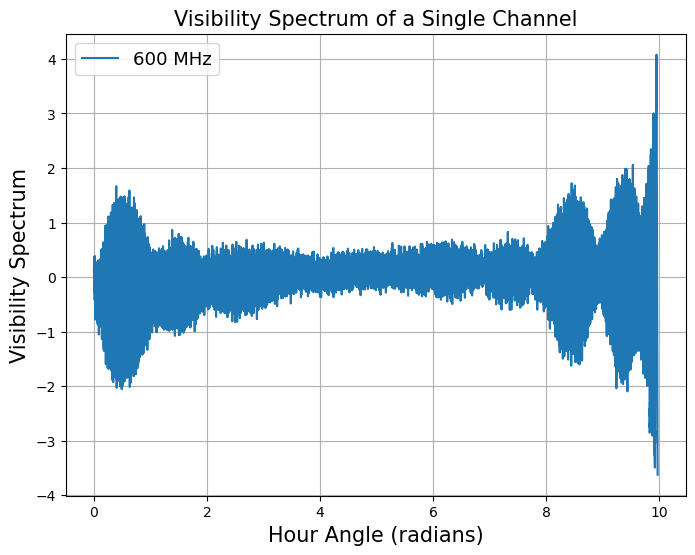

In [37]:
def graphSingleChannelOverTime(data, channel=600, xlim=None, ylim=None):
    # 450 < channel < 800
    plt.figure(figsize=graphSizeSingle)
    channel_data = normalize(data[:, channel])
    times = [(x*1.25)/3600 for x in range(len(data))]

    plt.plot(times, channel_data, label=f"{channel} MHz")
    plt.xlabel("Hour Angle (radians)", fontsize=axisSize)
    plt.ylabel("Visibility Spectrum", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Visibility Spectrum of a Single Channel", size=titleSize)
    plt.grid()
    plt.show()

graphSingleChannelOverTime(horizon_complex, channel=600)

In [38]:
def graphOverlayPowerSpectra(data, sample_rate, channel=600, indices=[5000, 10000, 20000, 25000], window=100, xlim=None):
    plt.figure(figsize=graphSizeSingle)
    channel_data = normalize(data[:, channel])

    for index in indices:
        spectrum = np.abs(fftshift(fft(channel_data[index-window:index+window]))) ** 2
        freqs = fftshift(fftfreq(len(spectrum), sample_rate))
        plt.plot(freqs, spectrum, label=f"Time Index = {index}", alpha=0.7)
   
    plt.xlim(xlim)
    plt.xlabel("Frequency (Hz)", fontsize=axisSize)
    plt.ylabel("Power (Arbitary Scale)", fontsize=axisSize)
    plt.title(f"Power Spectra at Different Times", size=titleSize)
    plt.legend()
    plt.grid(True)
    plt.show()

def graphFringeFreqOverTime(data, sample_rate=1.25, channel=600, resampling=True, window=300, vertical_line=None, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    channel_data = normalize(data[:, channel])
    #indices = np.linspace(101, len(channel_data) - 101, len(channel_data) - 202, dtype=int)
    #indices = np.linspace(301, len(channel_data) - 301, len(channel_data) - 602, dtype=int)
    #max_freqs = np.zeros(len(channel_data) - 202)
    #max_freqs = np.zeros(len(channel_data) - 602)

    indices = np.linspace(window+1, len(channel_data)-(window+1), len(channel_data)-2*(window+1), dtype=int)
    max_freqs = np.zeros(len(channel_data)-2*(window+1))


    for i, index in enumerate(indices):
        spectrum = np.abs(fft(channel_data[index-window:index+window])) ** 2        
        freqs = fftfreq(len(spectrum), d=1/sample_rate)

        bad_mask = (freqs >= -0.00) & (freqs <= 0.003)
        good_mask = ~bad_mask
        #max_freqs[i] = np.abs(freqs[np.argmax(spectrum[good_mask])])
        max_freq = np.abs(freqs[np.argmax(spectrum[good_mask])])
        if max_freq < 0.01 or max_freq > 0.07:
            max_freqs[i] = max_freqs[i-1]
        else:
            max_freqs[i] = max_freq

    # Accounting for weird vertical lines in data when it should be smooth
    if resampling:
        max_freqs[11100:11225] = max_freqs[11090]
        max_freqs[11225:11350] = max_freqs[11360]

    plt.scatter(indices, max_freqs, color='r', alpha=0.7)
   
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Timestep", fontsize=axisSize)
    plt.ylabel("Fringe Frequency", fontsize=axisSize)
    plt.title(f"Fringe Frequency Over Time", size=titleSize)
    plt.grid(True)
    if vertical_line is not None:
        plt.axvline(x=vertical_line, linestyle='--', color='blue', label=f'Noon (PST Standard Time)')
        plt.legend()
    plt.show()

    return max_freqs

#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[1000, 2000, 3000, 4000, 5000], channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[6000, 7000, 8000, 9000, 10000], channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[11000, 12000, 13000, 14000, 15000], window=200, channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[16000, 17000, 18000, 19000, 20000], channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[21000, 22000, 23000, 24000, 25000], channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[26000, 27000, 28000], channel=600, xlim=(0, 0.06))

#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[14000, 19000], window=200, channel=600, xlim=(0.028, 0.04))

#graphFringeFreqOverTime(horizon_imag, sample_rate=1.25, channel=600, mask=False, vertical_line=10769, ylim=(0, 0.07))
#graphFringeFreqOverTime(horizon_imag, sample_rate=1.25, channel=600, mask=True, vertical_line=107969, ylim=(0, 0.07))

noon_timestep = 10769
#graphOverlayPowerSpectra(horizon_complex, sample_rate=1.25, indices=[11001, 15000], window=100, channel=600, xlim=(-0.1, 0.1))
#graphOverlayPowerSpectra(horizon_complex, sample_rate=1.25, indices=[11001, 15000], window=250, channel=600, xlim=(-0.1, 0.1))
#graphOverlayPowerSpectra(horizon_complex, sample_rate=1.25, indices=[11001, 15000], window=300, channel=600, xlim=(-0.1, 0.1))

#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=325, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=335, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=345, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=350, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=355, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=360, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=365, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=370, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=375, vertical_line=noon_timestep, ylim=(0.01, 0.07))

In [39]:
time_data_jd = getTimesJD(data_horizon_raw_2)
time_data_utc = getTimesLocal(data_horizon_raw_2)
print("Started Mar 15, 8:32:19 AM PST")
print("Ended Mar 15, 6:30:41 PM PST")
print("Difference of 9hr, 58 mins, 22 sec (or 35902 total sec)")
print("28720 time steps")
print("1.25 seconds per time step")

Started Mar 15, 8:32:19 AM PST
Ended Mar 15, 6:30:41 PM PST
Difference of 9hr, 58 mins, 22 sec (or 35902 total sec)
28720 time steps
1.25 seconds per time step


In [40]:
time_data = getUnixTimes(data_horizon_raw_2)
time_data_jd = getTimesJD(data_horizon_raw_2)
LOC = EarthLocation(lat=37.873199*u.deg, lon=-122.257063*u.deg, height=120*u.m)
times = Time(time_data, format='unix', location=LOC)
LSTs = times.sidereal_time('apparent', longitude=LOC.lon).radian

RAs, DECs, HAs = np.zeros(len(time_data)), np.zeros(len(time_data)), np.zeros(len(time_data))
for i in range(len(time_data)):
    ra, dec = ugradio.coord.sunpos(time_data_jd[i])
    HAs[i] = LSTs[i] - np.radians(ra)
    DECs[i] = np.radians(dec)

w_earth = (2 * np.pi) / (24 * 60 * 60)
wavelen = 0.025
L = np.radians(37.873199)
b_ew_guess = 20
b_ns_guess = 0

In [41]:
def constructDesignMatrix(indices, observed_fringe_freqs, HAs, DECs, L, w_earth, wavelen, good_mask=None, undersample=False, step=5):
    if good_mask is None:
        good_mask = np.ones_like(indices, dtype=bool)

    indices_clean = indices[good_mask]
    HAs_clean = HAs[indices_clean]
    DECs_clean = DECs[indices_clean]
    observed_fringe_clean = np.array(observed_fringe_freqs)[good_mask]

    if undersample:
        indices_clean = indices_clean[::step]
        HAs_clean = HAs_clean[::step]
        DECs_clean = DECs_clean[::step]
        observed_fringe_clean = observed_fringe_clean[::step]

    A = (1 / wavelen) * np.cos(DECs_clean) * np.cos(HAs_clean)
    B = -(1 / wavelen) * np.sin(L) * np.cos(DECs_clean) * np.sin(HAs_clean)
    X = np.vstack([A, B]).T
    y = np.array(observed_fringe_clean) / w_earth

    return X, y, indices_clean, HAs_clean, DECs_clean, observed_fringe_clean

In [42]:
def fit_baseline_least_squares(X, y, initial_guess=(20.0, 0.0)):    
    def residuals(beta, X, y):
        b_ew, b_ns = beta
        return X @ np.array([b_ew, b_ns]) - y

    #lower_bounds = (18.5, -1.5)
    #upper_boudns = (21.5, 1.5)
    result = least_squares(residuals, initial_guess, args=(X, y))#, bounds=(lower_bounds, upper_boudns))
    
    # Estimate covariance and errors
    residuals_vec = result.fun
    N, p = len(y), 2
    sigma2 = np.sum(residuals_vec**2) / (N - p)
    cov = sigma2 * np.linalg.inv(X.T @ X)
    errors = np.sqrt(np.diag(cov))
    chi2_red = sigma2

    return result.x, errors, chi2_red, result

Window = 345


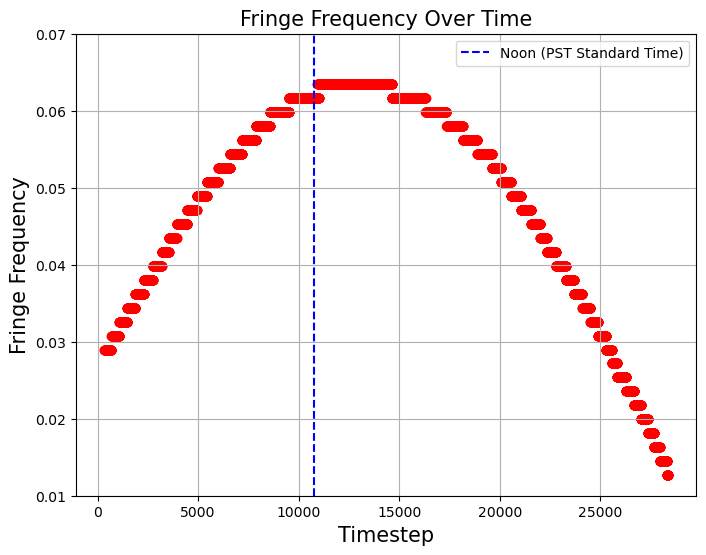

X shape: (94, 2)
y shape: (94,)
indices shape: (94,)
timestep 0: observed = 0.0289855, estimated = 0.018934
timestep 5000: observed = 0.048913, estimated = 0.0411518
timestep 10000: observed = 0.0615942, estimated = 0.0550099
timestep 15000: observed = 0.0615942, estimated = 0.0576925
timestep 20000: observed = 0.0507246, estimated = 0.048654
timestep 25000: observed = 0.0289855, estimated = 0.0297307
b_ew = 22.088 ± 0.051 m
b_ns = 1.847 ± 0.104 m
Reduced chi-squared = 239.249


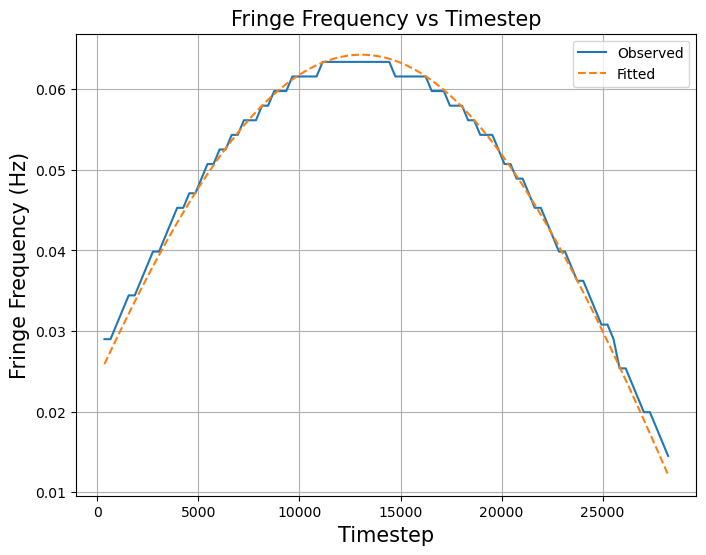

Window = 350


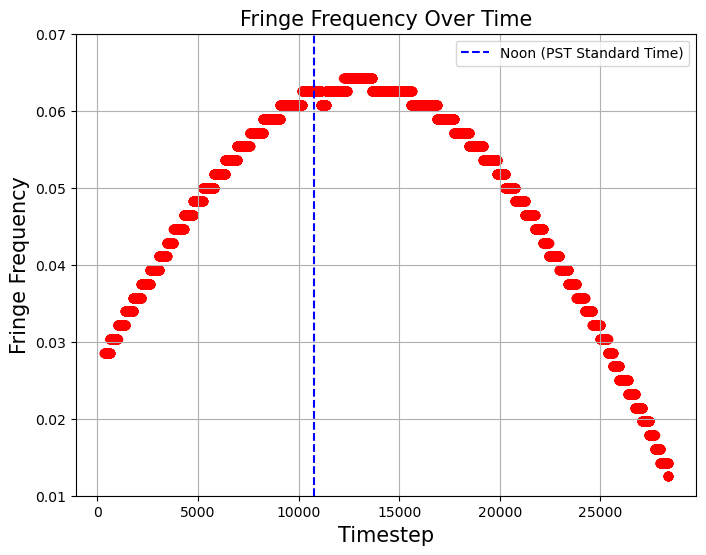

X shape: (94, 2)
y shape: (94,)
indices shape: (94,)
timestep 0: observed = 0.0285714, estimated = 0.018934
timestep 5000: observed = 0.05, estimated = 0.0411518
timestep 10000: observed = 0.0625, estimated = 0.0550099
timestep 15000: observed = 0.0625, estimated = 0.0576925
timestep 20000: observed = 0.05, estimated = 0.048654
timestep 25000: observed = 0.0303571, estimated = 0.0297307
b_ew = 22.065 ± 0.050 m
b_ns = 1.740 ± 0.102 m
Reduced chi-squared = 231.340


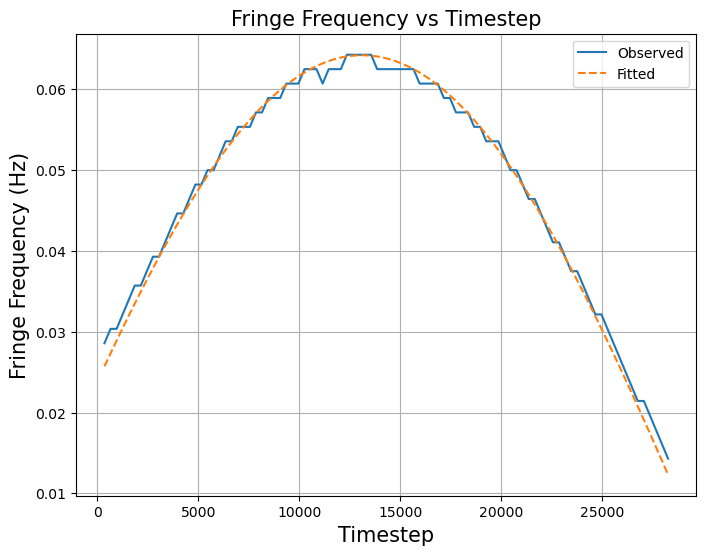

Window = 355


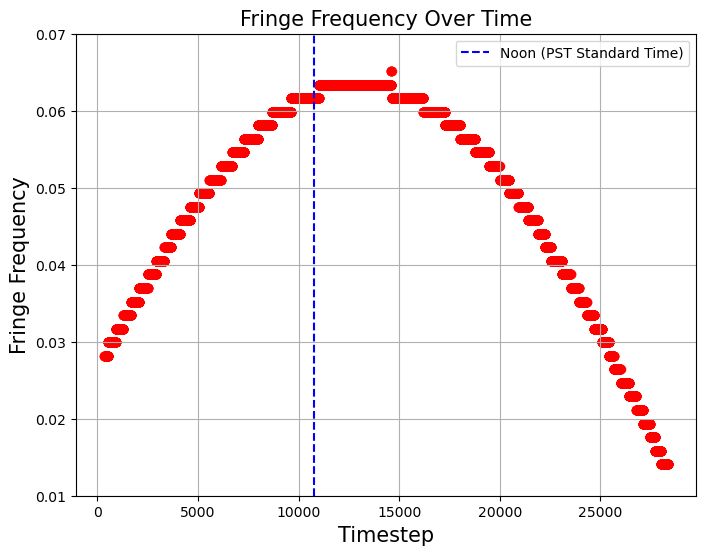

X shape: (94, 2)
y shape: (94,)
indices shape: (94,)
timestep 0: observed = 0.028169, estimated = 0.018934
timestep 5000: observed = 0.0492958, estimated = 0.0411518
timestep 10000: observed = 0.0616197, estimated = 0.0550099
timestep 15000: observed = 0.0616197, estimated = 0.0576925
timestep 20000: observed = 0.0510563, estimated = 0.048654
timestep 25000: observed = 0.0299296, estimated = 0.0297307
b_ew = 22.016 ± 0.049 m
b_ns = 1.815 ± 0.098 m
Reduced chi-squared = 215.169


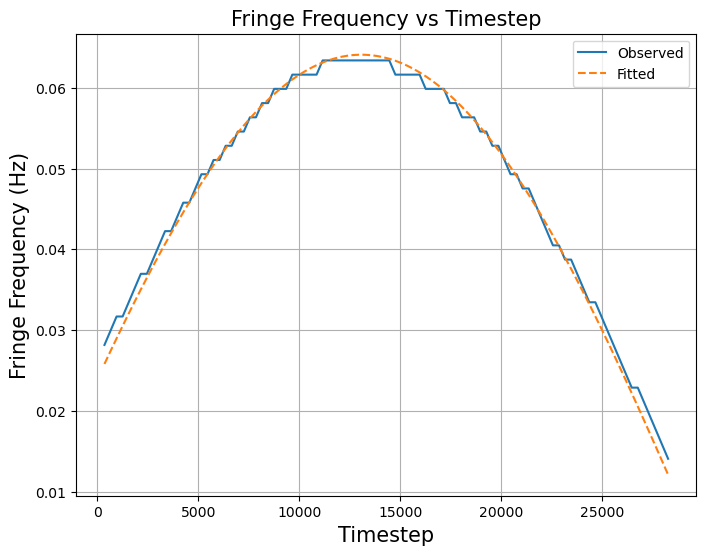

Window = 360


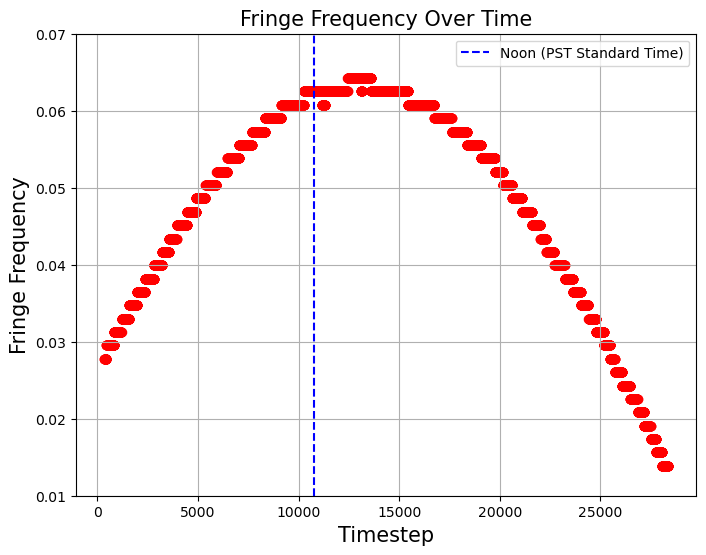

X shape: (94, 2)
y shape: (94,)
indices shape: (94,)
timestep 0: observed = 0.0277778, estimated = 0.018934
timestep 5000: observed = 0.0486111, estimated = 0.0411518
timestep 10000: observed = 0.0625, estimated = 0.0550099
timestep 15000: observed = 0.0625, estimated = 0.0576925
timestep 20000: observed = 0.0503472, estimated = 0.048654
timestep 25000: observed = 0.0295139, estimated = 0.0297307
b_ew = 22.000 ± 0.049 m
b_ns = 1.786 ± 0.099 m
Reduced chi-squared = 216.961


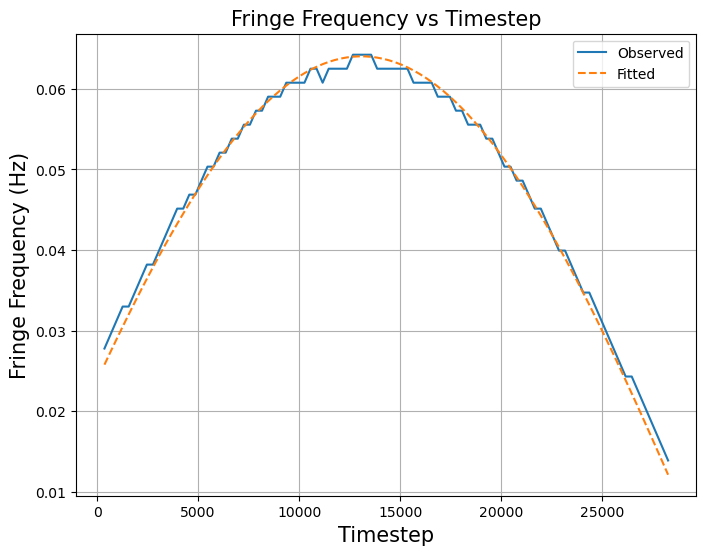

Window = 365


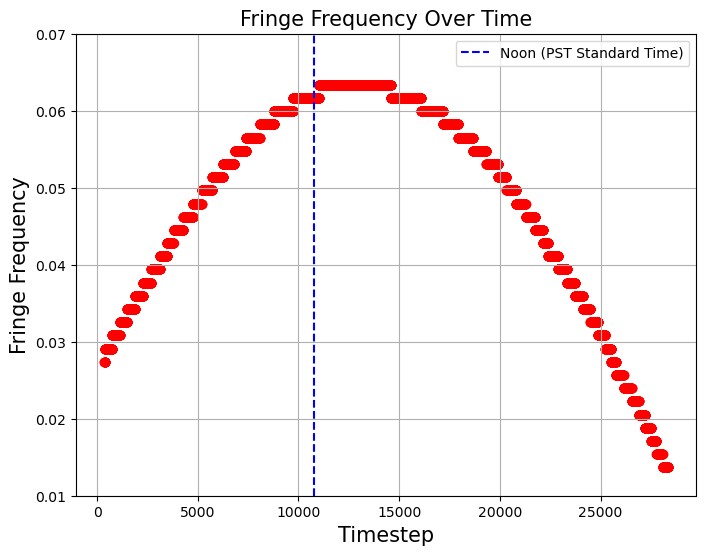

X shape: (94, 2)
y shape: (94,)
indices shape: (94,)
timestep 0: observed = 0.0273973, estimated = 0.018934
timestep 5000: observed = 0.0496575, estimated = 0.0411518
timestep 10000: observed = 0.0616438, estimated = 0.0550099
timestep 15000: observed = 0.0616438, estimated = 0.0576925
timestep 20000: observed = 0.0496575, estimated = 0.048654
timestep 25000: observed = 0.0291096, estimated = 0.0297307
b_ew = 21.995 ± 0.042 m
b_ns = 1.788 ± 0.084 m
Reduced chi-squared = 157.223


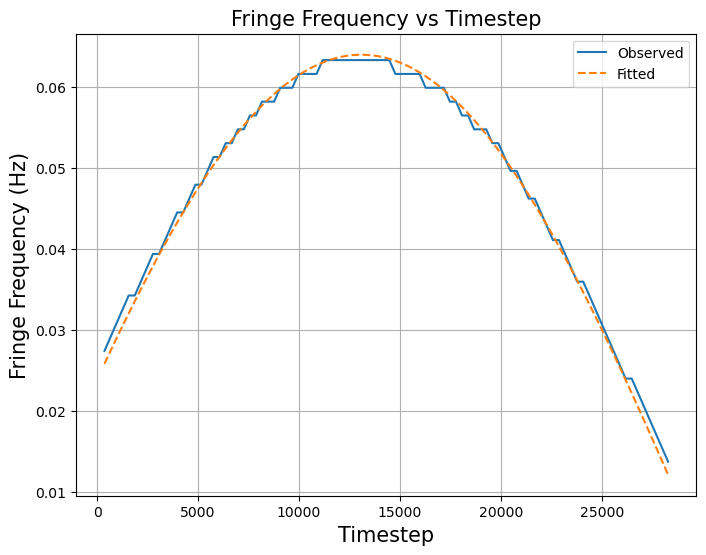

Window = 370


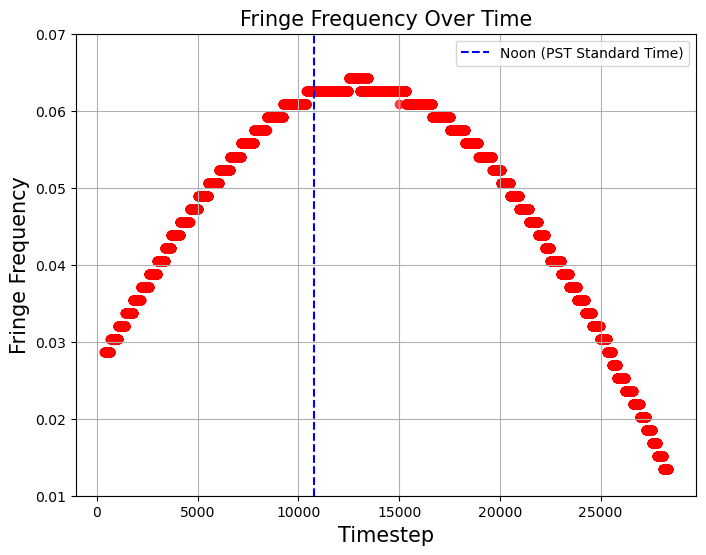

X shape: (94, 2)
y shape: (94,)
indices shape: (94,)
timestep 0: observed = 0.0287162, estimated = 0.018934
timestep 5000: observed = 0.0489865, estimated = 0.0411518
timestep 10000: observed = 0.0608108, estimated = 0.0550099
timestep 15000: observed = 0.0608108, estimated = 0.0576925
timestep 20000: observed = 0.0506757, estimated = 0.048654
timestep 25000: observed = 0.0287162, estimated = 0.0297307
b_ew = 21.967 ± 0.048 m
b_ns = 1.867 ± 0.097 m
Reduced chi-squared = 208.264


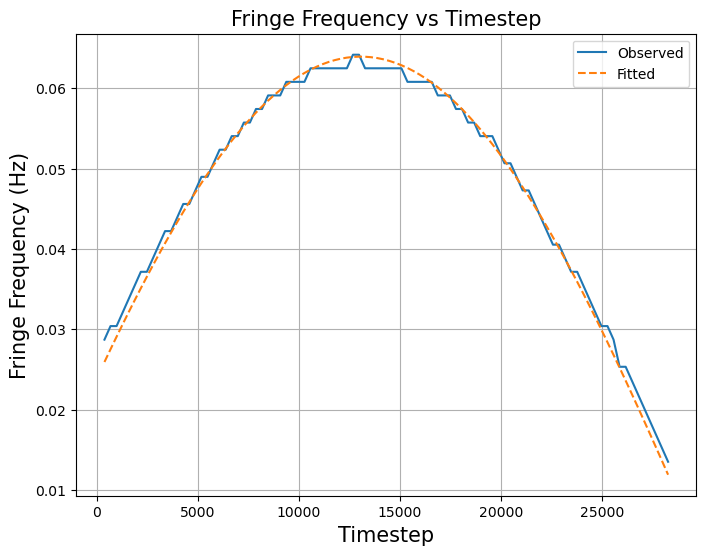

Window = 375


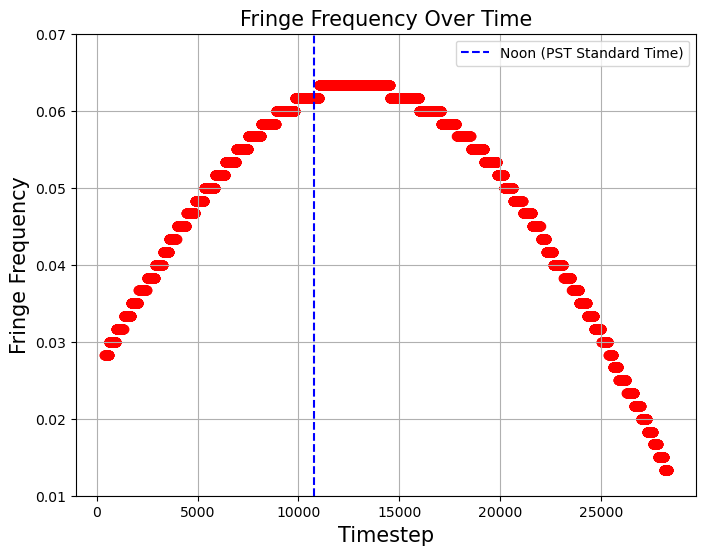

X shape: (94, 2)
y shape: (94,)
indices shape: (94,)
timestep 0: observed = 0.0283333, estimated = 0.018934
timestep 5000: observed = 0.05, estimated = 0.0411518
timestep 10000: observed = 0.0616667, estimated = 0.0550099
timestep 15000: observed = 0.0616667, estimated = 0.0576925
timestep 20000: observed = 0.05, estimated = 0.048654
timestep 25000: observed = 0.03, estimated = 0.0297307
b_ew = 21.994 ± 0.043 m
b_ns = 1.862 ± 0.087 m
Reduced chi-squared = 170.456


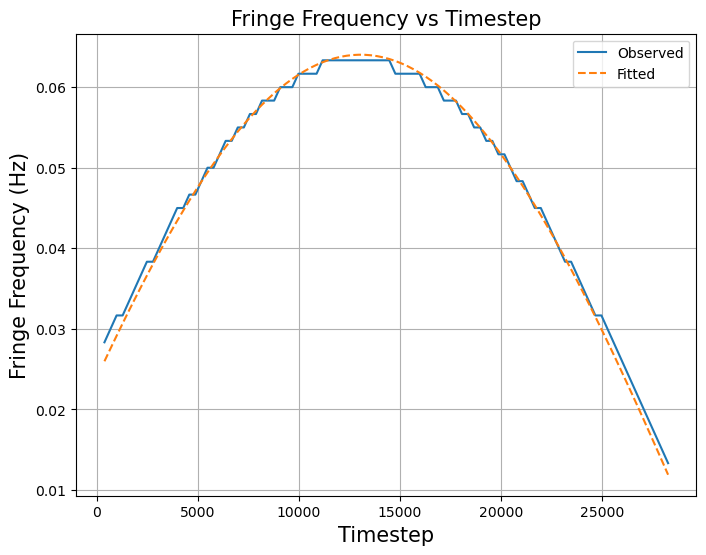

Window = 380


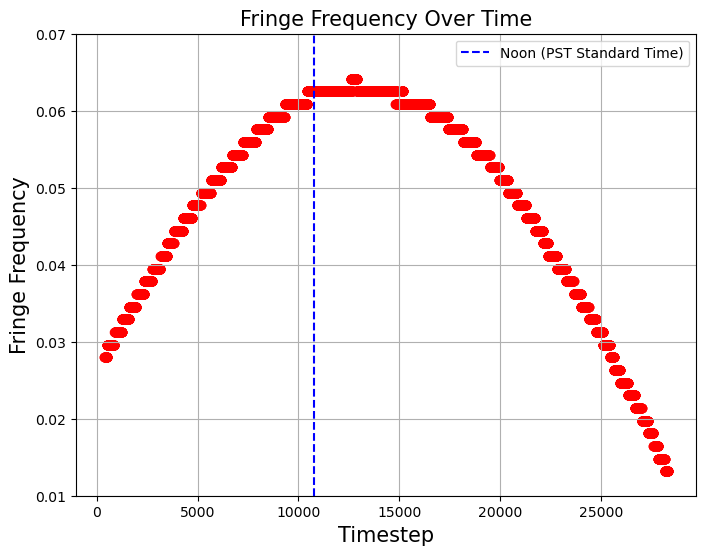

X shape: (94, 2)
y shape: (94,)
indices shape: (94,)
timestep 0: observed = 0.0279605, estimated = 0.018934
timestep 5000: observed = 0.0493421, estimated = 0.0411518
timestep 10000: observed = 0.0608553, estimated = 0.0550099
timestep 15000: observed = 0.0608553, estimated = 0.0576925
timestep 20000: observed = 0.0509868, estimated = 0.048654
timestep 25000: observed = 0.0296053, estimated = 0.0297307
b_ew = 21.898 ± 0.044 m
b_ns = 1.829 ± 0.089 m
Reduced chi-squared = 177.741


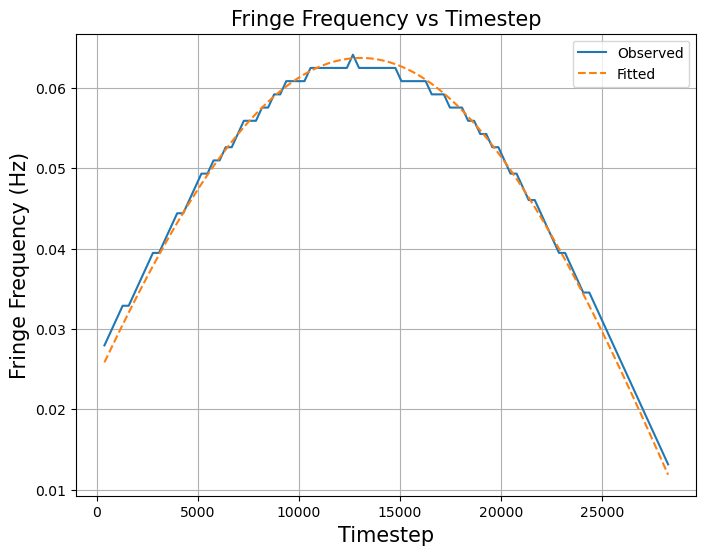

Window = 385


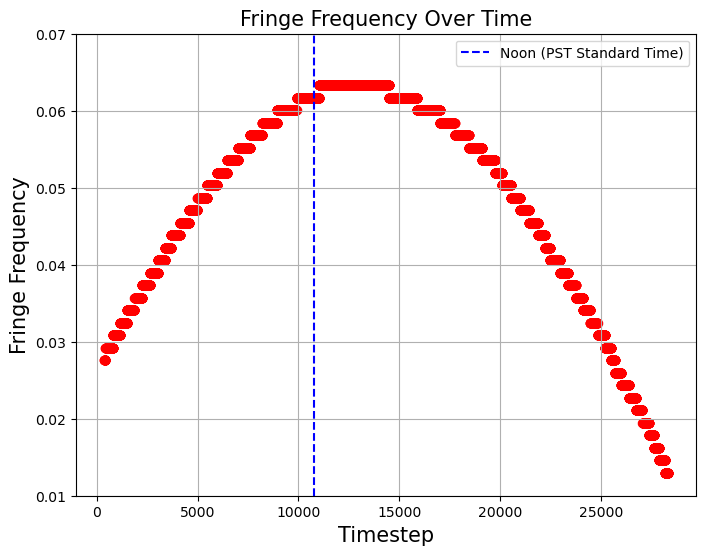

X shape: (94, 2)
y shape: (94,)
indices shape: (94,)
timestep 0: observed = 0.0275974, estimated = 0.018934
timestep 5000: observed = 0.0487013, estimated = 0.0411518
timestep 10000: observed = 0.0616883, estimated = 0.0550099
timestep 15000: observed = 0.0616883, estimated = 0.0576925
timestep 20000: observed = 0.0503247, estimated = 0.048654
timestep 25000: observed = 0.0292208, estimated = 0.0297307
b_ew = 21.929 ± 0.038 m
b_ns = 1.884 ± 0.076 m
Reduced chi-squared = 130.548


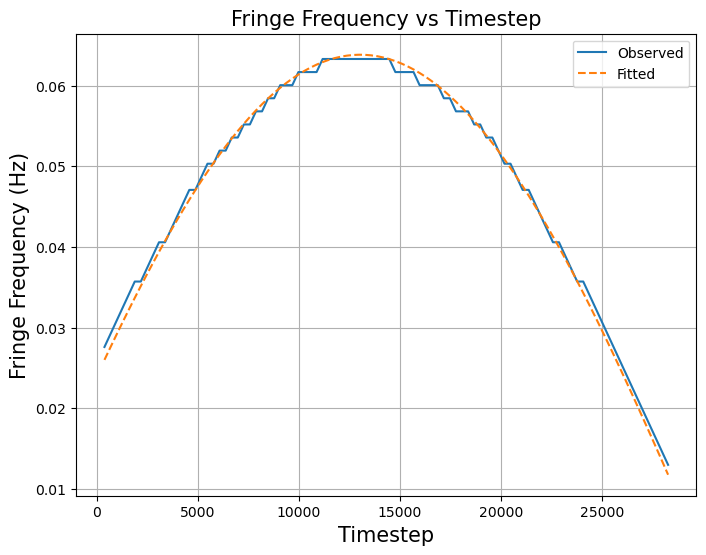

Window = 390


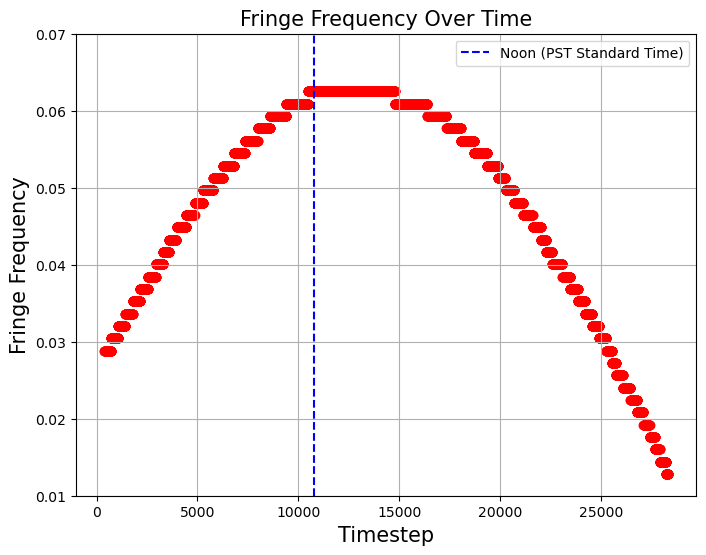

X shape: (94, 2)
y shape: (94,)
indices shape: (94,)
timestep 0: observed = 0.0288462, estimated = 0.018934
timestep 5000: observed = 0.0496795, estimated = 0.0411518
timestep 10000: observed = 0.0608974, estimated = 0.0550099
timestep 15000: observed = 0.0608974, estimated = 0.0576925
timestep 20000: observed = 0.0496795, estimated = 0.048654
timestep 25000: observed = 0.0288462, estimated = 0.0297307
b_ew = 21.865 ± 0.045 m
b_ns = 1.859 ± 0.092 m
Reduced chi-squared = 188.025


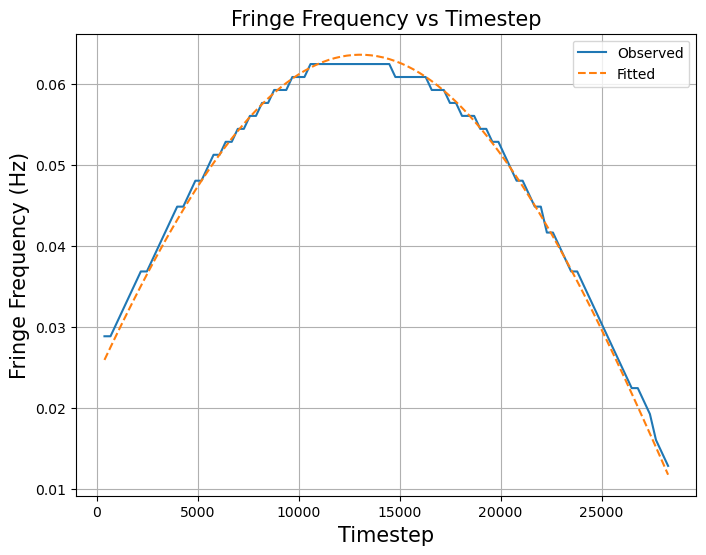

Window = 395


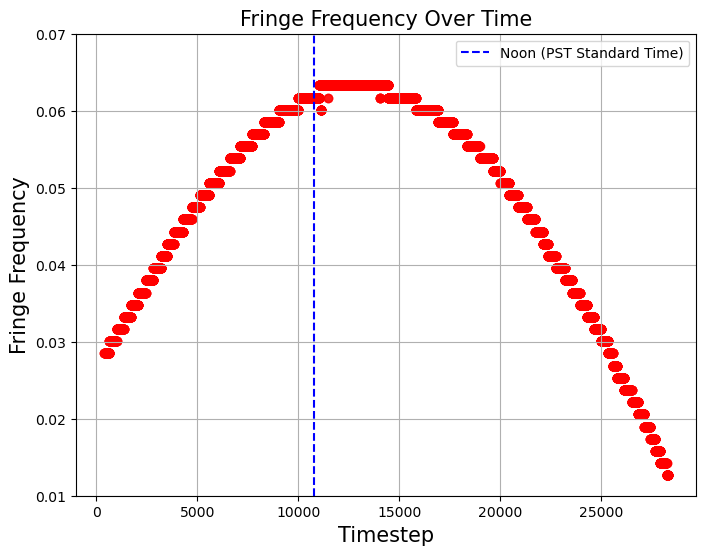

X shape: (94, 2)
y shape: (94,)
indices shape: (94,)
timestep 0: observed = 0.028481, estimated = 0.018934
timestep 5000: observed = 0.0490506, estimated = 0.0411518
timestep 10000: observed = 0.0617089, estimated = 0.0550099
timestep 15000: observed = 0.0617089, estimated = 0.0576925
timestep 20000: observed = 0.0506329, estimated = 0.048654
timestep 25000: observed = 0.028481, estimated = 0.0297307
b_ew = 21.915 ± 0.043 m
b_ns = 1.845 ± 0.086 m
Reduced chi-squared = 165.980


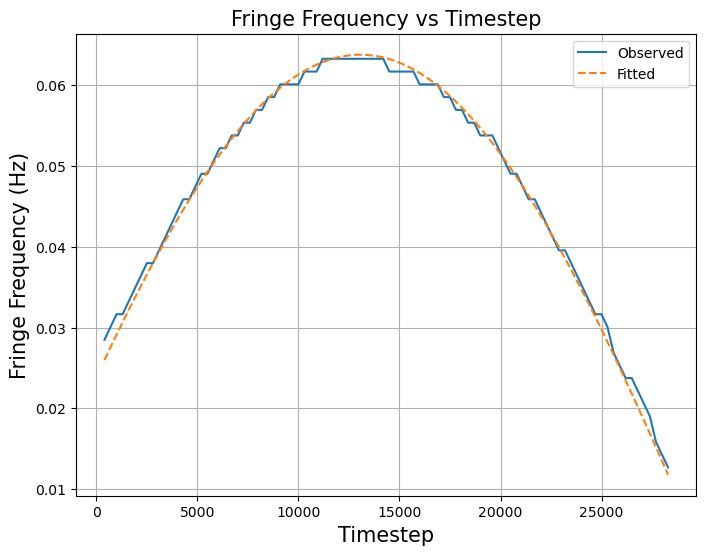

Window = 400


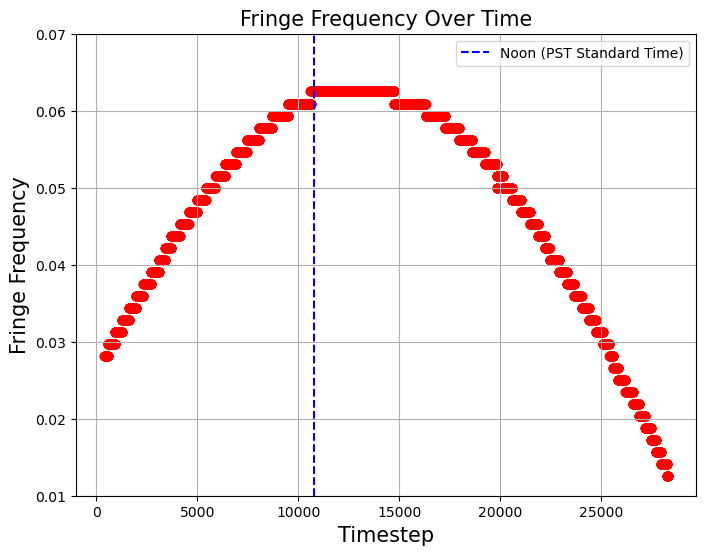

X shape: (94, 2)
y shape: (94,)
indices shape: (94,)
timestep 0: observed = 0.028125, estimated = 0.018934
timestep 5000: observed = 0.0484375, estimated = 0.0411518
timestep 10000: observed = 0.0609375, estimated = 0.0550099
timestep 15000: observed = 0.0609375, estimated = 0.0576925
timestep 20000: observed = 0.05, estimated = 0.048654
timestep 25000: observed = 0.0296875, estimated = 0.0297307
b_ew = 21.837 ± 0.045 m
b_ns = 1.812 ± 0.091 m
Reduced chi-squared = 182.901


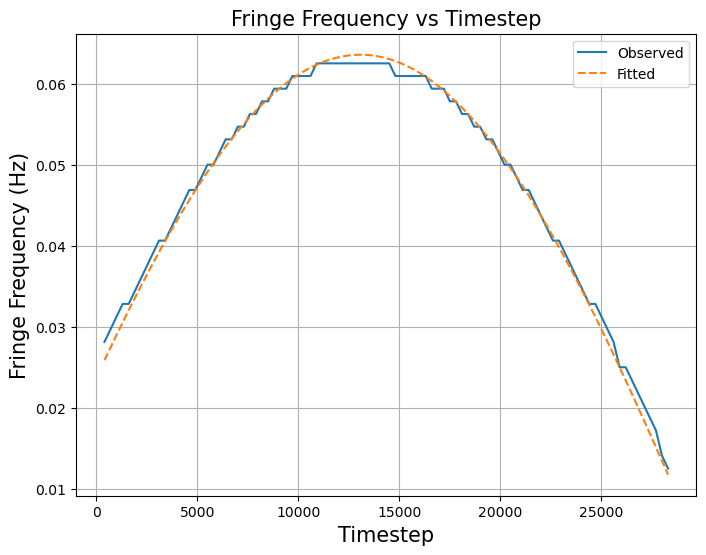

Window = 405


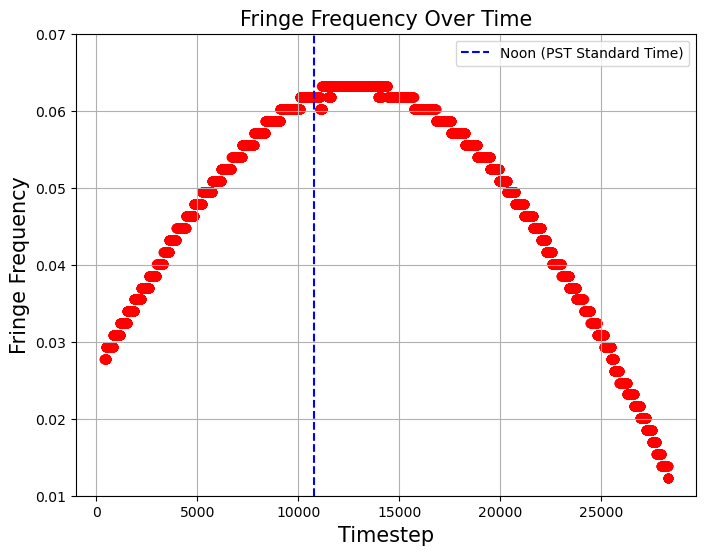

X shape: (94, 2)
y shape: (94,)
indices shape: (94,)
timestep 0: observed = 0.0277778, estimated = 0.018934
timestep 5000: observed = 0.0493827, estimated = 0.0411518
timestep 10000: observed = 0.0617284, estimated = 0.0550099
timestep 15000: observed = 0.0617284, estimated = 0.0576925
timestep 20000: observed = 0.0493827, estimated = 0.048654
timestep 25000: observed = 0.029321, estimated = 0.0297307
b_ew = 21.880 ± 0.041 m
b_ns = 1.852 ± 0.082 m
Reduced chi-squared = 151.193


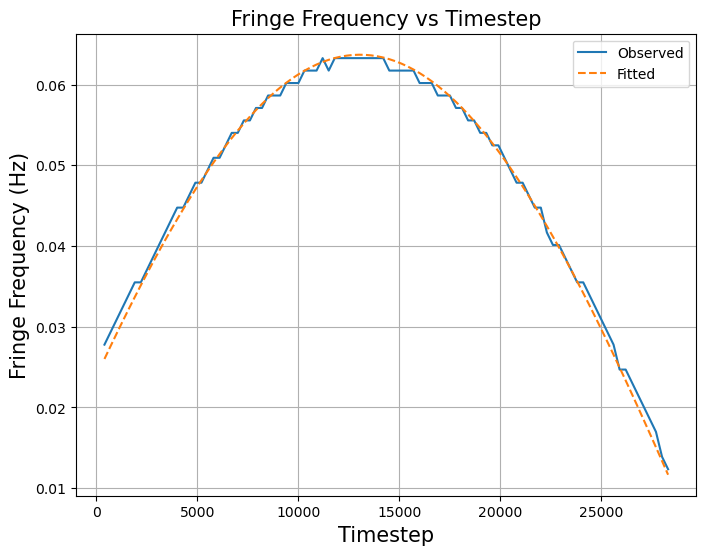

Window = 410


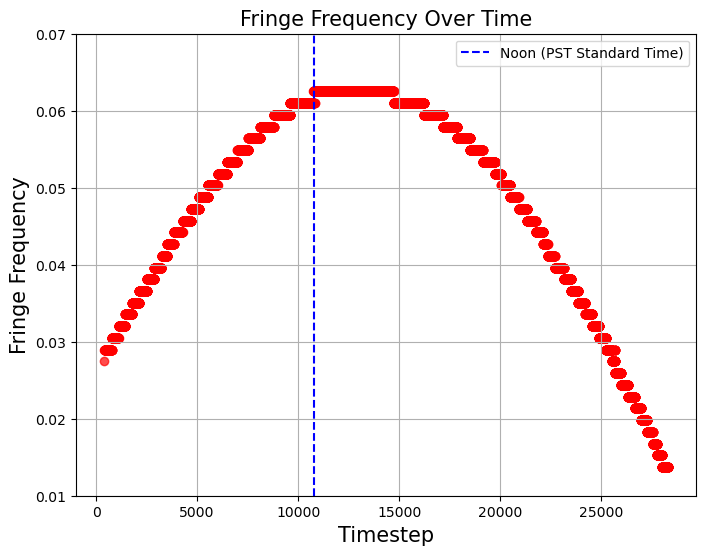

X shape: (93, 2)
y shape: (93,)
indices shape: (93,)
timestep 0: observed = 0.027439, estimated = 0.018934
timestep 5000: observed = 0.0487805, estimated = 0.0411518
timestep 10000: observed = 0.0609756, estimated = 0.0550099
timestep 15000: observed = 0.0609756, estimated = 0.0576925
timestep 20000: observed = 0.0503049, estimated = 0.048654
timestep 25000: observed = 0.0289634, estimated = 0.0297307
b_ew = 21.814 ± 0.039 m
b_ns = 1.845 ± 0.081 m
Reduced chi-squared = 141.671


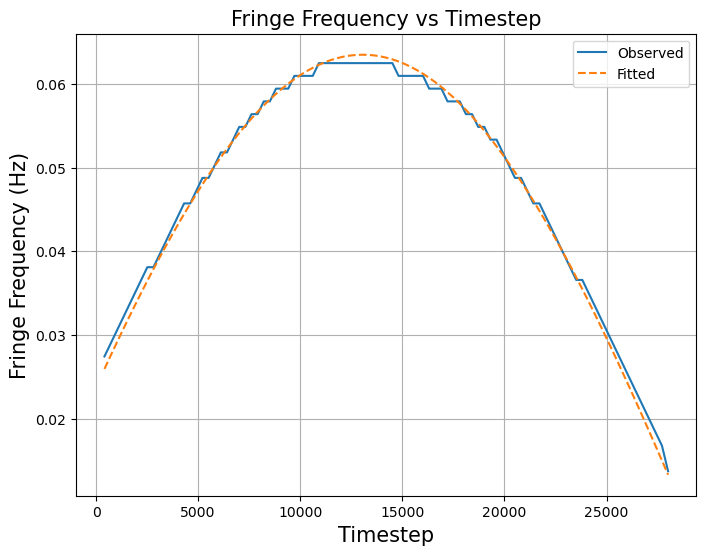

Window = 415


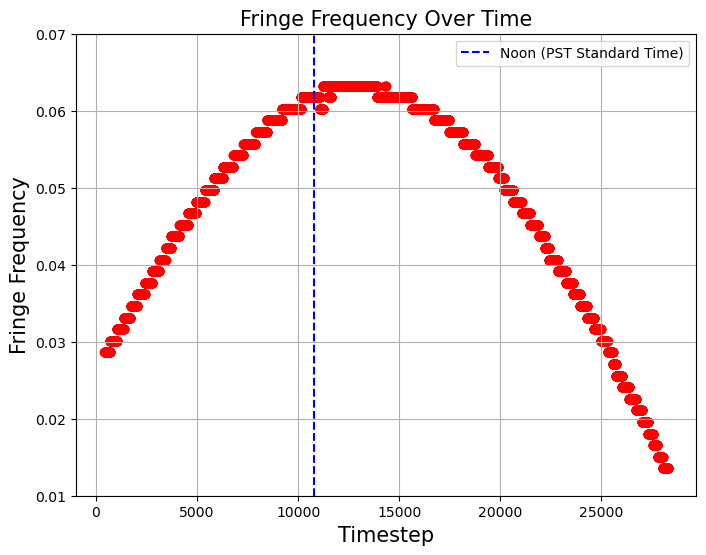

X shape: (93, 2)
y shape: (93,)
indices shape: (93,)
timestep 0: observed = 0.0286145, estimated = 0.018934
timestep 5000: observed = 0.0496988, estimated = 0.0411518
timestep 10000: observed = 0.061747, estimated = 0.0550099
timestep 15000: observed = 0.061747, estimated = 0.0576925
timestep 20000: observed = 0.0496988, estimated = 0.048654
timestep 25000: observed = 0.0286145, estimated = 0.0297307
b_ew = 21.795 ± 0.039 m
b_ns = 1.847 ± 0.080 m
Reduced chi-squared = 140.766


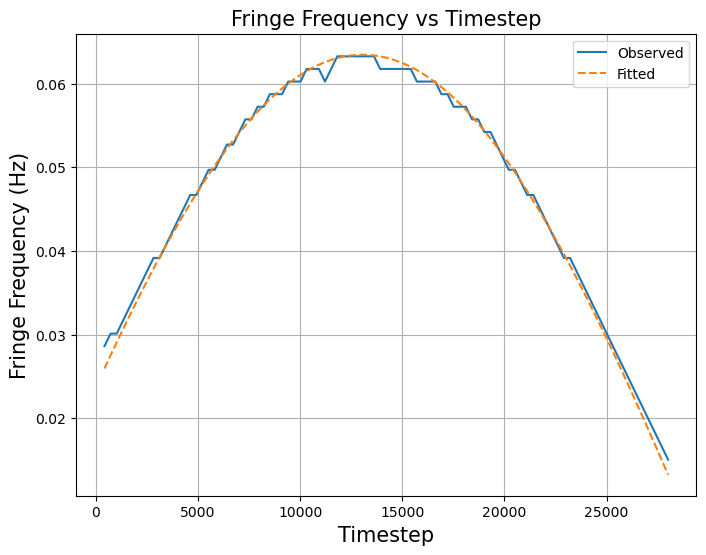

In [48]:
for window in range(345, 416, 5): #[345, 365, 400, 500, 600]:
    print(f"Window = {window}")
    observed_fringe_freqs = graphFringeFreqOverTime(horizon_complex, channel=600, window=window, resampling=True, vertical_line=noon_timestep, ylim=(0.01, 0.07))
    indices = np.linspace(window+1, len(horizon_complex)-(window+1), len(horizon_complex)-2*(window+1), dtype=int)

    X, y, indices_clean, HAs_clean, DECs_clean, observed_fringe_clean = constructDesignMatrix(
        indices, observed_fringe_freqs, HAs, DECs, L, w_earth, wavelen, good_mask=None, undersample=True, step=300
    )
    
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print("indices shape:", indices_clean.shape)

    estimated_fringe_freqs = []
    Q_ew = (b_ew_guess / wavelen) * np.cos(DECs)
    Q_ns = (b_ns_guess / wavelen) * np.sin(L) * np.cos(DECs)
    estimated_fringe_freqs = (Q_ew * np.cos(HAs) - Q_ns * np.sin(HAs)) * w_earth

    steps = 5000
    for i in range(0, len(observed_fringe_freqs), steps):
        obs = round(observed_fringe_freqs[i], 7)
        est = round(estimated_fringe_freqs[i], 7)
        print(f"timestep {i}: observed = {obs}, estimated = {est}")

    beta, errors, chi2_red, result_obj = fit_baseline_least_squares(X, y, initial_guess=(b_ew_guess, b_ns_guess))
    b_ew, b_ns = beta

    print(f"b_ew = {b_ew:.3f} ± {errors[0]:.3f} m")
    print(f"b_ns = {b_ns:.3f} ± {errors[1]:.3f} m")
    print(f"Reduced chi-squared = {chi2_red:.3f}")

    plt.figure(figsize=graphSizeSingle)

    plt.plot(indices_clean, y * w_earth, label='Observed')
    Q_ew = (b_ew / wavelen) * np.cos(DECs_clean)
    Q_ns = (b_ns / wavelen) * np.sin(L) * np.cos(DECs_clean)
    estimated = (Q_ew * np.cos(HAs_clean) - Q_ns * np.sin(HAs_clean)) * w_earth
    plt.plot(indices_clean, estimated, label='Fitted', linestyle='--')
    plt.xlabel('Timestep', fontsize=axisSize)
    plt.ylabel('Fringe Frequency (Hz)', fontsize=axisSize)
    plt.title('Fringe Frequency vs Timestep', size=titleSize)
    plt.legend()
    plt.grid(True)
    plt.show()

# Reduced Chi Squared for different windows:
# Undersampling = US

# Frequency Channel 600
#           No US:      US (s=300):                        
# 385:      151.273     130.548                                    
# 395:      142.692                     
# 405:      143.544                                      
# 415:      141.220      
# 
# Frequency Channel 540
#           No US:      US (s=300):   
# 385:      000000      135.696       
# 410:      000000      130.518     
# 
# # Frequency Channel 700
#           No US:      US (s=300):   
# 405:      138.081          
# 415:      133.321      133.654   

# 600 MHz, Window = 345, No undersampling, Red chi = 141.220, 
# Fit = b_ew = 21.822 ± 0.002 m, b_ns = 1.840 ± 0.005 m

# 600 MHz, Window = 385, Undersampling (step=300), Red chi = 130.548, 
# Fit = b_ew = 21.929 ± 0.038 m, b_ns = 1.884 ± 0.076 m

# 540 MHz, window = 410, Undersampling (step=300), Red chi = 130.518,
# Fit = b_ew = 21.802 ± 0.038 m, b_ns = 1.799 ± 0.077 m m

In [44]:
def compute_delta(jd_start, jd_end, num_time_steps):
    jds = np.linspace(jd_start, jd_end, num_time_steps)
    return [np.radians(ugradio.coord.sunpos(jds[i])[1]) for i in range(num_time_steps)]

def tau_g(h_s, b_ew, b_ns, delta, L, c=3e8):
    left_part = ((b_ew / c) * np.cos(delta)) * np.cos(h_s)
    right_part = (b_ns / c) * np.cos(L) * np.sin(delta)
    return left_part - right_part

def fringe_model(hs, A, B, freq, b_ew, b_ns, delta, L):
    # Eventually solving for A & B
    tau_g_vals = tau_g(hs, b_ew, b_ns, delta, L)
    left_part = A * np.cos(2 * np.pi * freq * tau_g_vals)
    right_part = B * np.sin(2 * np.pi * freq * tau_g_vals)
    return left_part + right_part

def compute_local_fringe_freq(data):
    time_steps = np.arange(data.shape[0])
    phase = np.unwrap(np.angle(data))
    fringe_freq = np.gradient(phase, time_steps) / (2 * np.pi)

    plt.figure(figsize=graphSizeSingle)
    plt.plot(time_steps, fringe_freq, label="Local Fringe Frequency", color='r')
    plt.xlabel('Time Steps', fontsize=axisSize)
    plt.ylabel('Frequency (Hz)', fontsize=axisSize)
    plt.title('Computed Local Fringe Frequency', size=titleSize)
    plt.legend(fontsize=legendSize)
    plt.grid()
    plt.show

    return fringe_freq

def fit_least_squares(data, b_ew, b_ns, dec, fringe_freq, L, xlim=None, ylim=None):
    time_steps = np.arange(data.shape[0])
    fringe = np.abs(data)

    tau_g_vals = tau_g(time_steps, b_ew, b_ns, dec, L)

    # Design matrix
    X = np.column_stack([np.cos(2 * np.pi * tau_g_vals), np.sin(2 * np.pi * tau_g_vals)])
    beta, residuals, _, _ = np.linalg.lstsq(X, fringe, rcond=None)
    A, B = beta

    fringe_amplitude = np.sqrt(A**2 + B**2)
    fitted_phase = np.arctan2(B, A)

    plt.figure(figsize=graphSizeSingle)
    plt.plot(time_steps, fringe, label="Measured Fringe")
    plt.plot(time_steps, fringe_model(time_steps, A, B, fringe_freq, b_ew, b_ns, dec, L), 
            label="Fitted Fringe", linestyle='dashed')

    plt.xlabel("Time Step", fontsize=axisSize)
    plt.ylabel("Fringe Amplitude (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Least Squares Fitting of Fringe Amplitude", size=titleSize)
    plt.grid()
    plt.show()

    return fringe_amplitude, fitted_phase, beta, residuals

b_ew = 20
b_ns = 0
dec = -0.03416507529584909
ha = -0.4217280392519642
fringe_freq = 0.05625
wavelen = 0.025
w_earth = (2 * np.pi) / (24 * 60 * 60)
L = np.radians(37.873199)

A = (1 / wavelen) * np.cos(dec) * np.cos(ha)
B = -(1 / wavelen) * np.sin(L) * np.cos(dec) * np.sin(ha)

lhs = fringe_freq / w_earth
X = np.array([[A, B]])
y = np.array([lhs])

[b_ew_fit, b_ns_fit], residuals, rank, s = lstsq(X, y, rcond=None)

print(f"Fit results:")
print(f"b_ew = {b_ew_fit:.3f} m")
print(f"b_ns = {b_ns_fit:.3f} m")

Fit results:
b_ew = 19.711 m
b_ns = 5.429 m


NOTES:  

dont do absolute value, keep real and complex data and find way to fix systematics (misalignment)?

waterfall plot for angle flip axes

non perfect bessel func bc not perfect disk (sun spot delta -> (FFT) -> flat function / baseline instead of 0)

In [ ]:
c = 3e8

def get_source_unit_vector(has, decs):
    # Both should be in radians
    x = np.cos(decs) * np.cos(has)
    y = np.cos(decs) * np.sin(has)
    z = np.sin(decs)
    return np.array([x, y, z]).T

def joint_vis_model(hs, b_ew, b_ns, decs, L, c=3e8):
    # hs should be in radians
    source_unit_vectors = get_source_unit_vector(hs, decs)
    tau_g_vals = tau_g(hs, b_ew, b_ns, decs, L)
    fringe_model_vals = np.exp(-1j * 2 * np.pi * tau_g_vals / c)
    return fringe_model_vals